**<h1>IMPORT LIBRARIES</h1>**

In [1]:
import os
import re
import pickle
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Embedding, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

**<h1>READ DATASET</h1>**

In [ ]:
data = pd.read_csv('./resetted_index_cleaned_polarity_roberta.csv', index_col=0)

In [ ]:
pos = data[data['sentiment'] == 'positive'].head(312564)
neu = data[data['sentiment'] == 'neutral'].head(312564)
neg = data[data['sentiment'] == 'negative'].head(312564)
df = pd.concat([pos, neu, neg], ignore_index=True)

In [ ]:
df['sentiment'] = df['sentiment'].replace({'positive': 0, 'negative': 1, 'neutral': 2})
df.head()

**<h1>SPLIT DATASET</h1>**

In [ ]:
X = df['cleaned_review'].tolist()
for index, value in enumerate(X):
    if isinstance(value, float):
        X[index] = str(value)

In [ ]:
y = to_categorical(df['sentiment'])
y = np.array(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

**<h1>TOKENIZATION</h1>**

In [2]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [3]:
shape = 96
batch_size = 64

In [ ]:
train_encodings = tokenizer(X_train, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

In [ ]:
test_encodings = tokenizer(X_test, padding='max_length', truncation=True, max_length=shape, return_tensors='tf')

## **LOAD TOKENIZATION**

In [4]:
save_path_train = './fix/train_encodings/'
save_path_test = './fix/test_encodings/'
save_path_y_train = './fix/y_train/y_train.tfrecord'
save_path_y_test = './fix/y_test/y_test.tfrecord'

In [5]:
serialized_tensor_train = tf.io.read_file(save_path_y_train)
serialized_tensor_test = tf.io.read_file(save_path_y_test)

In [6]:
loaded_tensor_train = tf.io.parse_tensor(serialized_tensor_train, out_type=tf.float32)
loaded_tensor_test = tf.io.parse_tensor(serialized_tensor_test, out_type=tf.float32)

In [7]:
loaded_y_train = loaded_tensor_train.numpy()
loaded_y_test = loaded_tensor_test.numpy()

In [8]:
loaded_train_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_train}/{key}.tfrecord")
    loaded_train_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

In [9]:
loaded_test_encodings = {}
for key in ['input_ids', 'attention_mask', 'token_type_ids']:
    tensor = tf.io.read_file(f"{save_path_test}/{key}.tfrecord")
    loaded_test_encodings[key] = tf.io.parse_tensor(tensor, out_type=tf.int32)

**<h1>CONVERT TO TENSORFLOW DATASET</h1>**

In [10]:
def create_tf_dataset(encodings, labels):
    return tf.data.Dataset.from_tensor_slices((
        encodings['input_ids'],  # Use only input_ids
        tf.constant(labels)
    )).batch(batch_size, drop_remainder=True)

In [11]:
train_tf_dataset = create_tf_dataset(loaded_train_encodings, loaded_y_train)
test_tf_dataset = create_tf_dataset(loaded_test_encodings, loaded_y_test)

**<h1>CNN MODEL</h1>**

In [12]:
model = Sequential([
    Embedding(input_dim=tokenizer.vocab_size, output_dim=768, input_length=shape),

    Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.45),

    Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.45),

    Conv1D(256, 3, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    GlobalMaxPooling1D(),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(3, activation='softmax')
])

**<h1>TRAIN MODEL</h1>**

In [13]:
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-2)
checkpoint = ModelCheckpoint('./fix/cnn_alone.keras', save_best_only=True, monitor='val_loss', mode='min')

In [15]:
history = model.fit(train_tf_dataset, epochs=50, validation_data=(test_tf_dataset), callbacks=[checkpoint, early_stopping, reduce_lr])

Epoch 1/50
10256/10256 [==============================] - 203s 19ms/step - loss: 1.6181 - accuracy: 0.3499 - val_loss: 1.4933 - val_accuracy: 0.4339 - lr: 1.0000e-05
Epoch 2/50
10256/10256 [==============================] - 196s 19ms/step - loss: 1.3438 - accuracy: 0.5335 - val_loss: 1.1683 - val_accuracy: 0.6456 - lr: 1.0000e-05
Epoch 3/50
10256/10256 [==============================] - 196s 19ms/step - loss: 1.1287 - accuracy: 0.6491 - val_loss: 1.0417 - val_accuracy: 0.6896 - lr: 1.0000e-05
Epoch 4/50
10256/10256 [==============================] - 196s 19ms/step - loss: 1.0179 - accuracy: 0.6891 - val_loss: 0.9634 - val_accuracy: 0.7130 - lr: 1.0000e-05
Epoch 5/50
10256/10256 [==============================] - 197s 19ms/step - loss: 0.9379 - accuracy: 0.7139 - val_loss: 0.8939 - val_accuracy: 0.7288 - lr: 1.0000e-05
Epoch 6/50
10256/10256 [==============================] - 197s 19ms/step - loss: 0.8727 - accuracy: 0.7311 - val_loss: 0.8569 - val_accuracy: 0.7325 - lr: 1.0000e-05
Epoc

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 768)           23440896  
                                                                 
 conv1d (Conv1D)             (None, 89, 64)            393280    
                                                                 
 batch_normalization (BatchN  (None, 89, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 44, 64)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 44, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           4

**<h1>HISTORY LOG</h1>**

In [17]:
with open('./fix/cnn_alone.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

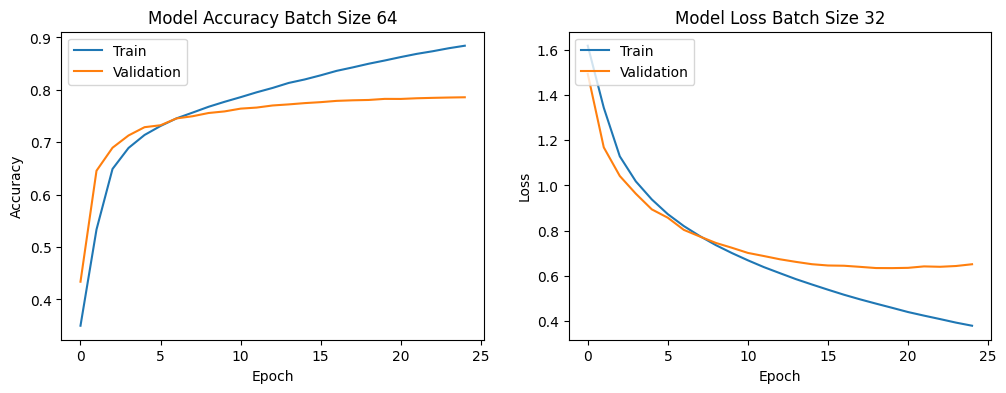

In [18]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy Batch Size 64')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss Batch Size 32')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(history)

In [19]:
loaded_model = load_model('./fix/cnn_alone.keras')

**<h1>VALIDATION</h1>**

In [20]:
y_pred_prob = loaded_model.predict(test_tf_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

4395/4395 [==============================] - 18s 4ms/step


In [21]:
y_true = np.concatenate([y for x, y in test_tf_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

In [22]:
conf_matrix = confusion_matrix(y_true, y_pred)

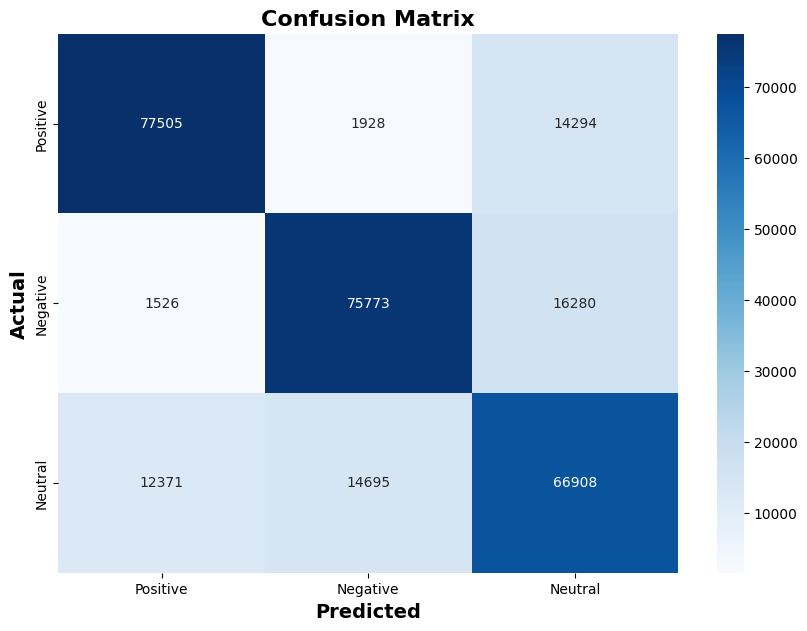

In [23]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()

In [24]:
print(classification_report(y_true, y_pred, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.85      0.83      0.84     93727
    Negative       0.82      0.81      0.81     93579
     Neutral       0.69      0.71      0.70     93974

    accuracy                           0.78    281280
   macro avg       0.78      0.78      0.78    281280
weighted avg       0.78      0.78      0.78    281280

